Synchronize DLC results with xr_session

In [63]:
%reload_ext autoreload
%autoreload 2
from trialexp.process.deeplabcut import utils as dlc_utils
import pandas as pd
import xarray as xr
import matplotlib.pylab as plt
import numpy as np
from moviepy.editor import *
from moviepy.video.io.bindings import mplfig_to_npimage
from IPython.display import Video
import seaborn as sns
from trialexp.process.pyphotometry.utils import make_event_xr, extract_event_data

In [2]:
fn = '06-14-23_14-40-49.000_TT002_Rig_3_Side_recode'
session_path = '/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/TT002-2023-06-14-144112/'
videofile = session_path +f'video/{fn}.mp4'

# Load DLC results

In [3]:
dftip = pd.read_pickle('dftip.pkl')
dfwrist = pd.read_pickle('dfwrist.pkl')

In [4]:
def add_video_timestamp(df,videofile):
    # add timestamp of the video file to the deeplabcut dataframe
    ts = dlc_utils.extract_video_timestamp(videofile)
    df['time'] = ts
    df = df.set_index('time')
    return df

dftip = dlc_utils.add_video_timestamp(dftip, videofile)
dfwrist = dlc_utils.add_video_timestamp(dfwrist, videofile)
    

In [5]:
xr_dlc = xr.DataArray([dfwrist,dftip], dims=('marker','time','coords'),
                 coords={'marker':['wrist','tip'],
                         'time':dfwrist.index,
                         'coords':['x','y','likelihood']
                 })

## Synchronize with the xr_session

In [6]:
xr_session = xr.open_dataset(session_path+'/processed/xr_session.nc')

# resample to the xr_session time
xr_dlc = xr_dlc.interp(time=xr_session.time)
xr_session['dlc_markers'] = xr_dlc

In [7]:
xr_session.to_netcdf('xr_session_dlc.nc', engine='h5netcdf')

In [8]:
wrist_loc = xr_session['dlc_markers'].loc['wrist',:,['x','y']]
tip_loc = xr_session['dlc_markers'].loc['tip',:,['x','y']]

## Get the photometry signal based on speed trigger

In [9]:
signal_time, coords, speed = dlc_utils.get_marker_signal(wrist_loc)

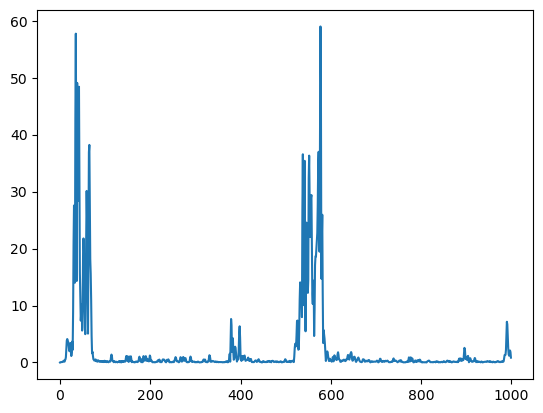

In [11]:
plt.plot(speed[:1000])

In [18]:
f = xr_session.zscored_df_over_f.data[0]
accel = np.diff(speed,prepend=speed[0])

df_vigor = pd.DataFrame({
    'accel': accel,
    'speed': speed,
    'df/f': f})
df_vigor

,accel,speed,df/f
0,0.000000,0.000000,0.205254
1,0.057733,0.057733,0.292358
2,-0.014141,0.043592,0.262030
3,0.027108,0.070699,0.201862
4,0.015841,0.086541,0.231352
...,...,...,...
176423,0.047227,0.658829,0.003056
176424,2.613453,3.272282,0.031638
176425,1.856771,5.129054,0.086082
176426,-0.771006,4.358047,0.064148


<Axes: xlabel='accel', ylabel='df/f'>

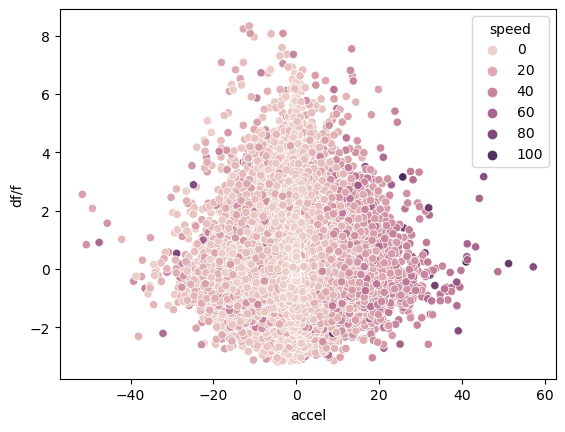

In [21]:
sns.scatterplot(df_vigor, x='accel', y='df/f', hue='speed')

<Axes: xlabel='speed', ylabel='df/f'>

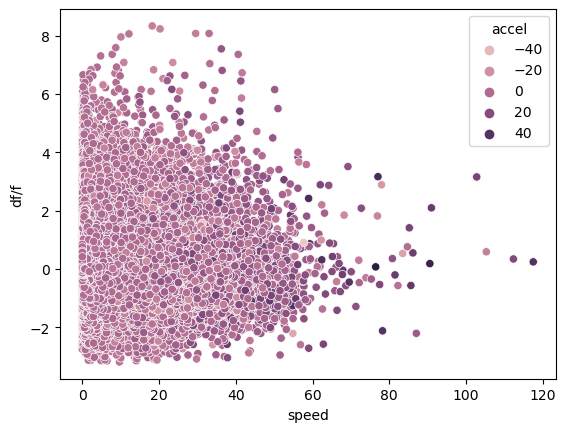

In [23]:
sns.scatterplot(df_vigor, x='speed', y='df/f', hue='accel')

## Identify contagious regions

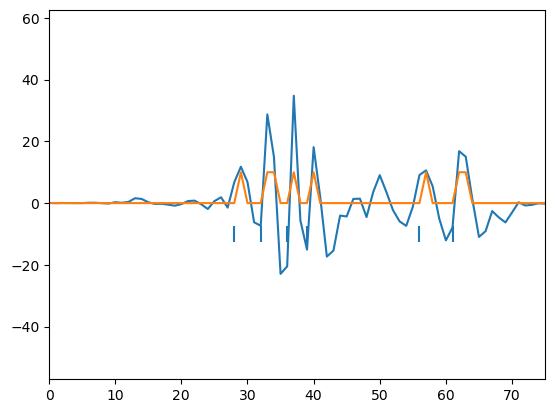

In [55]:
fig,ax = plt.subplots()

a = np.diff(speed)
ax.plot(a)
ax.plot((a>10)*10)
ax.set_xlim([0,75])

condition  = (a>10).astype(np.int8)
event_idx = np.where(np.diff(condition)==1)[0]
ax.eventplot(event_idx, lineoffset=-10, linelength=5)

event_time = xr_session.time[event_idx]

(0.0, 200.0)

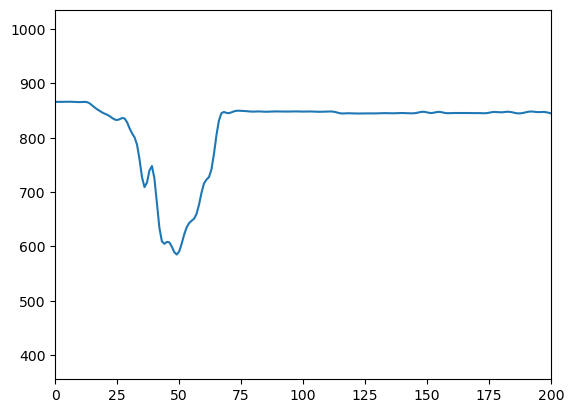

In [33]:
plt.plot(coords[:,0])
plt.xlim([0,200])

In [104]:
trial_window = xr_session.trial_window
sampling_rate = xr_session.attrs['sampling_rate']
event_period = (trial_window[1] - trial_window[0])/1000
event_time_coord= np.linspace(trial_window[0], trial_window[1], int(event_period*sampling_rate)) #TODO

#note the event time here refer to the relative time
data, event_found = extract_event_data(event_time, trial_window, xr_session['zscored_df_over_f'], sampling_rate)


In [120]:
da = xr.DataArray(
        data, coords={'event_time':event_time_coord,
                     'event_index': np.arange(data.shape[0])},
                        dims=('event_index','event_time'))


da = da.coarsen(event_time=10,boundary='trim').mean()
df = da.to_dataframe(name='photometry').reset_index()

<Axes: xlabel='event_time', ylabel='photometry'>

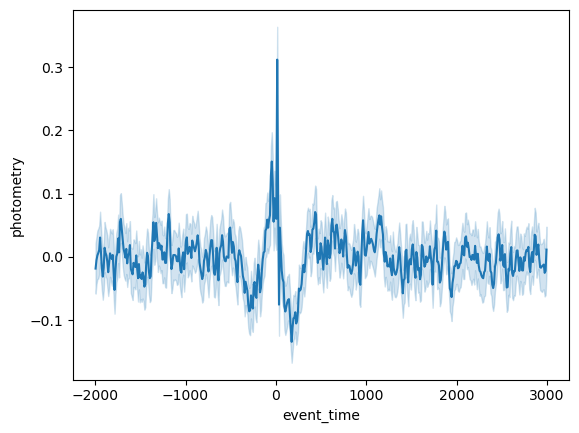

In [124]:
sns.lineplot(df, x='event_time', y='photometry')

 Things to study
 - Forward aceleration and backward acceleration
 - acceleraton and deceleration

<Axes: xlabel='event_time', ylabel='photometry'>

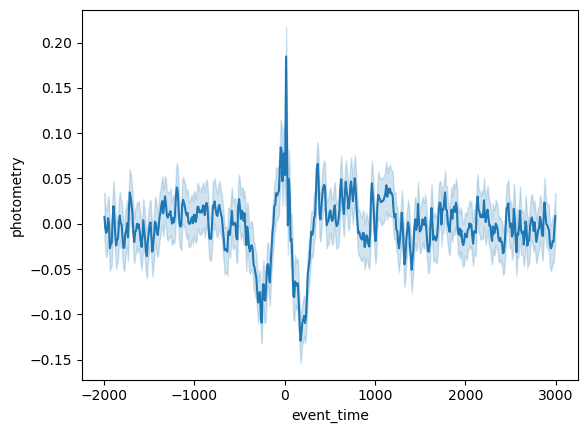

In [126]:
condition  = (a>5).astype(np.int8)
event_idx = np.where(np.diff(condition)==1)[0]
event_time = xr_session.time[event_idx]
data, event_found = extract_event_data(event_time, trial_window, xr_session['zscored_df_over_f'], sampling_rate)

da = xr.DataArray(
        data, coords={'event_time':event_time_coord,
                     'event_index': np.arange(data.shape[0])},
                        dims=('event_index','event_time'))


da = da.coarsen(event_time=10,boundary='trim').mean()
df = da.to_dataframe(name='photometry').reset_index()

sns.lineplot(df, x='event_time', y='photometry')

<Axes: xlabel='event_time', ylabel='photometry'>

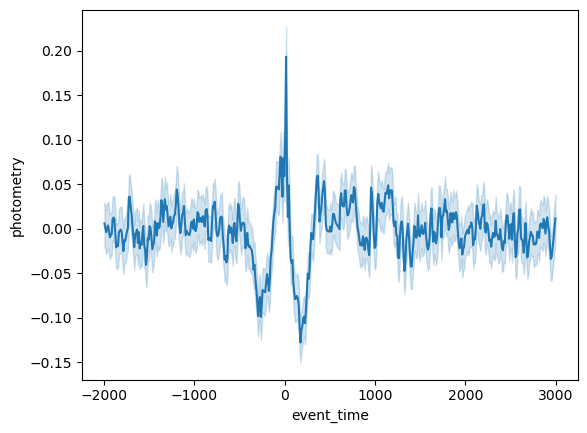

In [127]:
condition  = (a<-5).astype(np.int8)
event_idx = np.where(np.diff(condition)==1)[0]
event_time = xr_session.time[event_idx]
data, event_found = extract_event_data(event_time, trial_window, xr_session['zscored_df_over_f'], sampling_rate)

da = xr.DataArray(
        data, coords={'event_time':event_time_coord,
                     'event_index': np.arange(data.shape[0])},
                        dims=('event_index','event_time'))


da = da.coarsen(event_time=10,boundary='trim').mean()
df = da.to_dataframe(name='photometry').reset_index()

sns.lineplot(df, x='event_time', y='photometry')